In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [140]:
winter_path = '../data/raw/winter.csv'
summer_path = '../data/raw/summer.csv'

winter_df = pd.read_csv(winter_path)
summer_df = pd.read_csv(summer_path)

display(winter_df.head())
display(summer_df.head())

,Year,City,Sport,Discipline,Country,Gender,Event,Medal,Athlete
0,1924,Chamonix,Biathlon,Biathlon,FIN,Men,Military Patrol,Silver,FIN
1,1924,Chamonix,Biathlon,Biathlon,FRA,Men,Military Patrol,Bronze,FRA
2,1924,Chamonix,Biathlon,Biathlon,SUI,Men,Military Patrol,Gold,SUI
3,1924,Chamonix,Bobsleigh,Bobsleigh,BEL,Men,Four-Man,Bronze,BEL
4,1924,Chamonix,Bobsleigh,Bobsleigh,GBR,Men,Four-Man,Silver,GBR


,Year,City,Sport,Discipline,Country,Gender,Event,Medal,Athlete
0,1896,Athens,Aquatics,Swimming,AUT,Men,100M Freestyle,Silver,"HERSCHMANN, Otto"
1,1896,Athens,Aquatics,Swimming,AUT,Men,400M Freestyle,Gold,"NEUMANN, Paul"
2,1896,Athens,Aquatics,Swimming,GRE,Men,100M Freestyle For Sailors,Bronze,"DRIVAS, Dimitrios"
3,1896,Athens,Aquatics,Swimming,GRE,Men,100M Freestyle For Sailors,Gold,"MALOKINIS, Ioannis"
4,1896,Athens,Aquatics,Swimming,GRE,Men,100M Freestyle For Sailors,Silver,"CHASAPIS, Spiridon"


In [141]:
winter_medals  = winter_df.groupby(['Year', 'Country']).agg(
    gold_medal=('Medal', lambda x: (x == 'Gold').sum()),
    silver_medal=('Medal', lambda x: (x == 'Silver').sum()),
    bronze_medal=('Medal', lambda x: (x == 'Bronze').sum()),
    total_medal=('Medal', lambda x: x.count())
).reset_index()
winter_medals['type_olympic'] = 'w'

summer_medals  = summer_df.groupby(['Year', 'Country']).agg(
    gold_medal=('Medal', lambda x: (x == 'Gold').sum()),
    silver_medal=('Medal', lambda x: (x == 'Silver').sum()),
    bronze_medal=('Medal', lambda x: (x == 'Bronze').sum()),
    total_medal=('Medal', lambda x: x.count())
).reset_index()
summer_medals['type_olympic'] = 's'

display(winter_medals.head())
display(summer_medals.head())

,Year,Country,gold_medal,silver_medal,bronze_medal,total_medal,type_olympic
0,1924,AUT,3,1,0,4,w
1,1924,BEL,0,0,1,1,w
2,1924,CAN,1,0,0,1,w
3,1924,FIN,4,5,3,12,w
4,1924,FRA,0,0,4,4,w


,Year,Country,gold_medal,silver_medal,bronze_medal,total_medal,type_olympic
0,1896,AUS,2,0,0,2,s
1,1896,AUT,2,1,2,5,s
2,1896,DEN,1,2,3,6,s
3,1896,FRA,5,4,2,11,s
4,1896,GBR,2,3,2,7,s


In [142]:
combined_medals = pd.concat([winter_medals, summer_medals])

display(combined_medals.head())
display(combined_medals.info())

,Year,Country,gold_medal,silver_medal,bronze_medal,total_medal,type_olympic
0,1924,AUT,3,1,0,4,w
1,1924,BEL,0,0,1,1,w
2,1924,CAN,1,0,0,1,w
3,1924,FIN,4,5,3,12,w
4,1924,FRA,0,0,4,4,w


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1774 entries, 0 to 1335
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Year          1774 non-null   int64 
 1   Country       1774 non-null   object
 2   gold_medal    1774 non-null   int64 
 3   silver_medal  1774 non-null   int64 
 4   bronze_medal  1774 non-null   int64 
 5   total_medal   1774 non-null   int64 
 6   type_olympic  1774 non-null   object
dtypes: int64(5), object(2)
memory usage: 110.9+ KB


None

In [143]:
country_code_map = {
    "DEU": "GER",
    "LVA": "LAT",
    "NLD": "NED",
    "SVN": "SLO",
    "CHE": "SUI",
    "BHR": "BAH",
    "PRT": "POR",
    "DNK": "DEN",
    "HRV": "CRO",
    "BGR": "BUL",
    "PHL": "PHI"
}

In [144]:
host_path = '../data/raw/city_host.csv'
host_df = pd.read_csv(host_path,skiprows=1)

display(host_df.head(10))

host_df['Country Code'] = host_df['Country Code'].apply(lambda x: country_code_map.get(x, x))
host_df['Year'] = host_df['Year'].astype(int) 
host_filtered = host_df[host_df['Year'] <= 2022]

,Year,Country,Country Code,City
0,1900,France,FRA,Paris
1,1904,USA,USA,St. Louis
2,1908,UK,GBR,London
3,1912,Sweden,SWE,Stockholm
4,1920,Belgium,BEL,Antwerp
5,1924,France,FRA,Paris
6,1924,France,FRA,Chamonix
7,1928,Netherlands,NLD,Amsterdam
8,1928,Switzerland,CHE,St. Moritz
9,1932,USA,USA,Los Angeles


In [145]:
combined_medals['host_flag'] = combined_medals.apply(
    lambda row: 1 if ((host_filtered['Year'] == row['Year']) & (host_filtered['Country Code'] == row['Country'])).any() else 0,
    axis=1
)
#host_summary = host_filtered.groupby('Country Code').size().reset_index(name='Number of Times Hosted')

# Display the grouped dataframe
display(combined_medals.info())
combined_medals.to_csv('../data/processed/medals.csv',index=False)
print('combined_medals was saved')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1774 entries, 0 to 1335
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Year          1774 non-null   int64 
 1   Country       1774 non-null   object
 2   gold_medal    1774 non-null   int64 
 3   silver_medal  1774 non-null   int64 
 4   bronze_medal  1774 non-null   int64 
 5   total_medal   1774 non-null   int64 
 6   type_olympic  1774 non-null   object
 7   host_flag     1774 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 124.7+ KB


None

combined_medals was saved


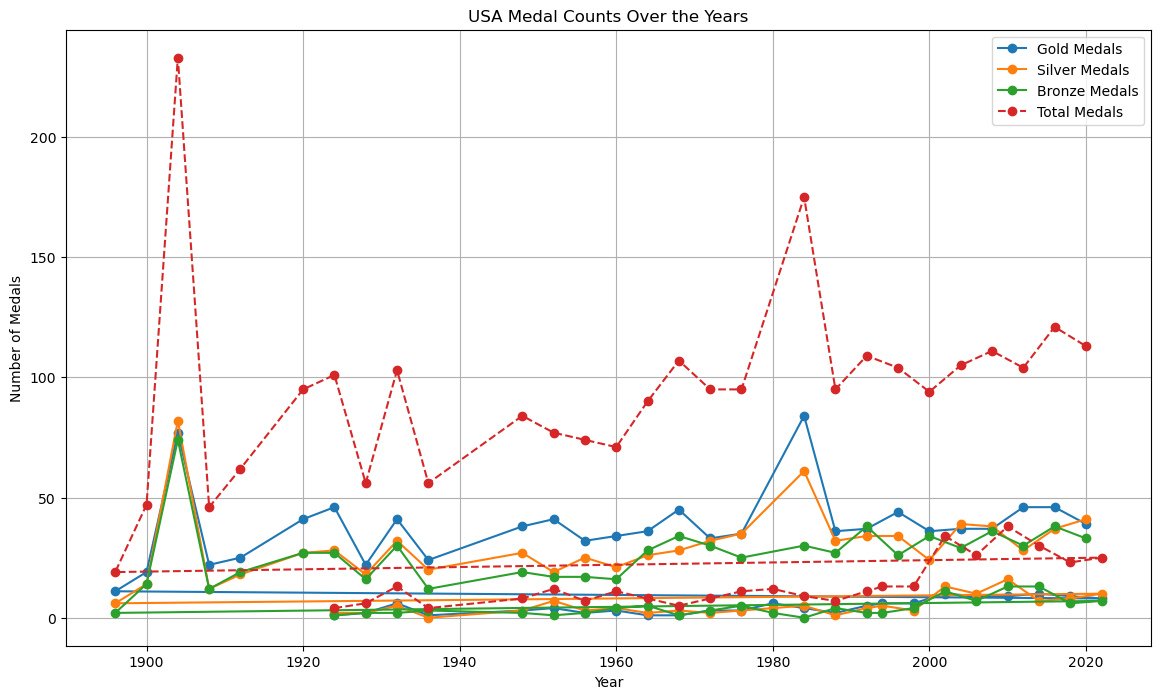

In [146]:
usa_data = combined_medals[combined_medals['Country'] == 'USA']

# Plot trends of medal counts over the years
plt.figure(figsize=(14, 8))
plt.plot(usa_data['Year'], usa_data['gold_medal'], label='Gold Medals', marker='o')
plt.plot(usa_data['Year'], usa_data['silver_medal'], label='Silver Medals', marker='o')
plt.plot(usa_data['Year'], usa_data['bronze_medal'], label='Bronze Medals', marker='o')
plt.plot(usa_data['Year'], usa_data['total_medal'], label='Total Medals', marker='o', linestyle='--')

plt.xlabel('Year')
plt.ylabel('Number of Medals')
plt.title('USA Medal Counts Over the Years')
plt.legend()
plt.grid(True)
plt.show()

In [147]:
wdicountry_path = '../data/raw/WDICountry.csv'
wdicsv_path = '../data/raw/WDICSV.csv'

country_df = pd.read_csv(wdicountry_path)
data_df = pd.read_csv(wdicsv_path)

In [148]:
country = country_df[['Country Code','Region','Income Group']]
country = country[~country['Region'].isnull()]
country.loc[country['Country Code'] == 'VEN', 'Income Group'] = 'Low income'

In [149]:
data_df[data_df['Country Code'].isin([country['Country Code']])]['Country Name']

Series([], Name: Country Name, dtype: object)

In [150]:
#filtered_df = data_df[data['Indicator Code'].isin(indicators)]
#save = filtered_df[['Country Code','Indicator Code','2016', '2017', '2018', '2019', '2020', '2021', '2022']]
#save.to_csv('../data/processed/save.csv')
data=data_df[['Country Code','Indicator Code','2016', '2017', '2018', '2019', '2020', '2021','2022']]


In [151]:
indicators = [
    'NY.GDP.MKTP.CD',    # GDP (current US$)
    'NY.GDP.PCAP.CD',    # GDP per capita (current US$)
    'SP.DYN.LE00.IN',    # Life expectancy at birth (years)
    'SH.XPD.PCAP.CD',    # Health expenditure per capita (current US$)
    'SH.XPD.CHEX.GD.ZS', # Health expenditure, total (% of GDP)
    'SE.PRM.ENRR',       # Adjusted net enrollment rate, primary (% of primary school age children)
    'SE.PRM.CMPT.ZS',    # Primary completion rate, total (% of relevant age group)
    'SE.SEC.ENRR',       # Secondary school enrollment, gross (% of secondary school age children)
    'SE.TER.ENRR',       # Tertiary school enrollment, gross (% of tertiary school age population)
    'EG.ELC.ACCS.ZS',    # Access to electricity (% of population)
    'EG.CFT.ACCS.ZS',    # Access to clean fuels and technologies for cooking (% of population)
    'IT.NET.USER.ZS',    # Internet users (% of population)
    'IT.CEL.SETS.P2',    # Mobile cellular subscriptions (per 100 people)
    'SL.EMP.TOTL.SP.ZS', # Employment to population ratio, 15+, total (% of total population ages 15+)
    'SL.TLF.ACTI.ZS',    # Labor force participation rate, total (% of total population ages 15+)
    'SL.UEM.TOTL.ZS',    # Unemployment, total (% of total labor force)
    'EN.ATM.CO2E.PC',    # CO2 emissions (metric tons per capita)
    'NY.ADJ.SVNX.GN.ZS', # Adjusted savings: education expenditure (% of GNI)
    'NY.ADJ.DRES.GN.ZS', # Adjusted savings: natural resources depletion (% of GNI)
    'SP.POP.TOTL',       # Population, total
    'SP.POP.GROW',       # Population growth (annual %)
    'AG.LND.TOTL.K2',    # Land area (sq. km)
    'SP.URB.TOTL.IN.ZS', # Urban population (% of total)
    'SP.RUR.TOTL.ZS'     # Rural population (% of total population)
]

In [152]:
filtered_df = data[data['Indicator Code'].isin(indicators)]

In [153]:
long_df = pd.melt(filtered_df, id_vars=['Country Code','Indicator Code'], var_name='Year', value_name='Value')

data = long_df.pivot_table(
    index=['Country Code', 'Year'],
    columns='Indicator Code',
    values='Value'
).reset_index()

data.columns.name = None

display(data.head())

,Country Code,Year,AG.LND.TOTL.K2,EG.CFT.ACCS.ZS,EG.ELC.ACCS.ZS,EN.ATM.CO2E.PC,IT.CEL.SETS.P2,IT.NET.USER.ZS,NY.ADJ.DRES.GN.ZS,NY.ADJ.SVNX.GN.ZS,...,SE.TER.ENRR,SH.XPD.CHEX.GD.ZS,SL.EMP.TOTL.SP.ZS,SL.TLF.ACTI.ZS,SL.UEM.TOTL.ZS,SP.DYN.LE00.IN,SP.POP.GROW,SP.POP.TOTL,SP.RUR.TOTL.ZS,SP.URB.TOTL.IN.ZS
0,ABW,2016,180.0,NaN,100.0,NaN,NaN,93.542454,0.003503,8.280000,...,18.43368,NaN,NaN,NaN,NaN,75.617,0.590062,104874.0,56.808,43.192
1,ABW,2017,180.0,NaN,100.0,NaN,NaN,97.170000,0.002992,7.313862,...,NaN,NaN,NaN,NaN,NaN,75.903,0.537296,105439.0,56.707,43.293
2,ABW,2018,180.0,NaN,100.0,NaN,NaN,NaN,0.002020,4.158809,...,NaN,NaN,NaN,NaN,NaN,76.072,0.494795,105962.0,56.589,43.411
3,ABW,2019,180.0,NaN,100.0,NaN,132.466508,NaN,0.001760,8.521691,...,NaN,NaN,NaN,NaN,NaN,76.248,0.451970,106442.0,56.454,43.546
4,ABW,2020,180.0,NaN,100.0,NaN,132.288784,NaN,0.003119,-2.678666,...,NaN,NaN,NaN,NaN,NaN,75.723,0.134255,106585.0,56.303,43.697


In [154]:
data_m=pd.merge(data,country,on='Country Code')

In [155]:
data_m.head()
data_m.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1519 entries, 0 to 1518
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Country Code       1519 non-null   object 
 1   Year               1519 non-null   object 
 2   AG.LND.TOTL.K2     1296 non-null   float64
 3   EG.CFT.ACCS.ZS     1323 non-null   float64
 4   EG.ELC.ACCS.ZS     1505 non-null   float64
 5   EN.ATM.CO2E.PC     955 non-null    float64
 6   IT.CEL.SETS.P2     1375 non-null   float64
 7   IT.NET.USER.ZS     1187 non-null   float64
 8   NY.ADJ.DRES.GN.ZS  1055 non-null   float64
 9   NY.ADJ.SVNX.GN.ZS  872 non-null    float64
 10  NY.GDP.MKTP.CD     1459 non-null   float64
 11  NY.GDP.PCAP.CD     1463 non-null   float64
 12  SE.PRM.CMPT.ZS     887 non-null    float64
 13  SE.PRM.ENRR        1113 non-null   float64
 14  SE.SEC.ENRR        931 non-null    float64
 15  SE.TER.ENRR        895 non-null    float64
 16  SH.XPD.CHEX.GD.ZS  1139 

In [156]:
data_m.sort_values(by=['Country Code', 'Year'], inplace=True)
data_m.fillna(method='ffill', inplace=True)
data_m.fillna(method='bfill', inplace=True)

# Fill remaining missing values by mean within each 'Income Group' and 'Region'
for column in data_m.columns:
    if data_m[column].dtype in ['float64', 'int64']:
        data_m[column] = data_m.groupby(['Income Group', 'Region'])[column].transform(lambda x: x.fillna(x.mean()))

# Check if there are still missing values
missing_values = data_m.isnull().sum()
print(missing_values[missing_values > 0])

Series([], dtype: int64)


In [157]:
data_m['Country Code'] = data_m['Country Code'].apply(lambda x: country_code_map.get(x, x))
data = data_m[data_m['Year'].isin(['2020','2022'])]

data.to_csv('../data/processed/data.csv',index=False)
print('data_m was saved')

data_m was saved
